#### DNN 기반 다중분류 모델 구현
- 데이터셋 : iris.csv
- 피쳐/라벨 : 4개 sepal.length, sepal.width, petal.length, petal.width
- 타겟/라벨 : 1개 variety
- 학습 방법 : 지도 학습 > 분류 > 이진분류
- 학습 알고리즘 : 인공신경망(ANN) => 심층신경막(입력층, 은닉층, 출력층 있는거) MLP , DNN : 은닉층이 많은 구성
- 프레임 워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비 <hr>

In [1]:
# 모듈 로딩
# 1. 모델관련
import torch                                    # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn                           # 인공신경망 관련 모듈
import torch.nn.functional as F                 # 손실, 거리 등 함수 관련 모듈

# 2. 데이터 셋 관련                    
from torch.utils.data import DataLoader, Dataset

# 3. 최적화에 관련
import torch.optim as optim    # 최적화 기법 관련 모듈

# 4. 모델 평가
from torchmetrics.classification import MulticlassF1Score

# 5. 모델의 구조를 보는 모듈
from torchinfo import summary                   # 모델 정보 관련 모듈

# 6. Data 관련
import pandas as pd                 # 데이터 파일 분석 관련 모듈
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

In [2]:
# 활용 패키지 버전 체크 ==> 사용자 정의 함수로 구현하세요~~
print(f'Pytroch v.{torch.__version__}')
print(f'Pandas v.{pd.__version__}')

Pytroch v.2.4.1
Pandas v.2.0.3


In [3]:
# 데이터 로딩
DATA_file ='../data/iris.csv'

# CSV >> DF
irisDF = pd.read_csv(DATA_file)

# 확인
irisDF.head(1)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa


In [4]:
### 타겟 변경 >> 정수화, 클래스 3개
irisDF['variety'].unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [5]:
# 타겟 정수화
labels = dict(zip(irisDF['variety'].unique().tolist(), range(3)))
print(f'label => {labels}')

# 라벨인코딩
irisDF['variety'] = irisDF['variety'].replace(labels)
irisDF.head(1)

label => {'Setosa': 0, 'Versicolor': 1, 'Virginica': 2}


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0


[2] 모델 클래스 설계 및 정의 <hr>
- 클래스 목적 : iris 데이터를 학습 및 추론 목적
- 클래스 이름 : IrisMCFModel
- 부모 클래스 : nn.Module
- 매개 변수 : 층별 입출력 개수 고정하기 때문에 필요 없음
- 속성 필드 :
- 기능 역할(필수 메서드) 
    * _ _init_ _() - 모델 구조 설정
    * forward() - 순방향 학습       << 오버라이딩(overriding)

- 클래스 구조 (임의의 설정값)
    * 입력층 - 입력  4개 (피쳐 개수) >  출력 10개 (퍼셉트론 / 뉴런 10개 존재)
    * 은닉층 - 입력 10개            >  출력  5개 (퍼셉트론 / 뉴런 5개 존재)
    * 출력층 - 입력  5개            >  출력  1개 (퍼셉트론 / 뉴런 1개 존재, 2진분류)

- 활성화함수 종류
    * 클래스 형태 ==> nn.MESLose, nn.ReLU ==> _ _init_ _() 메서드
    * 함수 형태 ==> torch.nn.functional 아래에 ==> forward() 메서드

In [6]:
class IrisMCMModel(nn.Module):

    # 모델 구조 구성 및 인스턴스 생성 메서드
    def __init__(self):
        super().__init__()

        self.in_layer = nn.Linear(4,10)
        self.hd_layer = nn.Linear(10,5)
        self.out_layer = nn.Linear(5,3) # 다중분류 클래스 3개개
                                        # 'Setosa','Versicolor','Virginica' > 종류 3개

    # 순방향(forward) 학습 진행 메서드 
    def forward(self, input_data):

        # 입력층 
        y = self.in_layer(input_data)   
        y = F.relu(y)                  

        # 은닉층 : 10개의 숫자 값(y >= 0)
        y=self.hd_layer(y)
        y = F.relu(y)

        # 출력층 : 5개의 숫자 값(y >= 0) >> 다중 분류 : 손실함수 CrossEntropyLoss 내부에서 softmax 진행
        return self.out_layer(y)

In [7]:
# 모델 인스턴스 생성
model = IrisMCMModel()
print(model)

IrisMCMModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hd_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=3, bias=True)
)


In [8]:
### 모델 사용 메로리 정보 확인
summary(model, input_size=(5,4)) # 데이터양, 피쳐개수

Layer (type:depth-idx)                   Output Shape              Param #
IrisMCMModel                             [5, 3]                    --
├─Linear: 1-1                            [5, 10]                   50
├─Linear: 1-2                            [5, 5]                    55
├─Linear: 1-3                            [5, 3]                    18
Total params: 123
Trainable params: 123
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

[3] 데이터셋 클래스 설계 및 정의 <hr>
- 데이터셋 : iris.csv
- 피쳐 개수 : 4개
- 타겟 개수 : 1개 [타겟 안에 있는 클래스는 3개]
- 클래스 이름 : IrisDataset
- 부모클래스 : utils.data.Dataset
- 속성_필드 : featuresDF, targetDF, n_rows, n_features
- 필수메서드
    * __init__(self) : 데이터셋 저장 및 전처리, 개발자가 필요한 속성 설정
    * __len__(self) : 데이터의 개수 반환
    * __getitme__(self, index) : 특정 인덱스의 피쳐와 타겟 반환

In [9]:
class IrisDataset(Dataset):
    def __init__(self, featureDF, targetDF):
        self.featureDF = featureDF
        self.targetDF = targetDF
        self.n_rows = featureDF.shape[0] # >> 새로 속성 추가
        self.n_features = featureDF.shape[1] # >> 새로 속성 추가
    
    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):
    
        # 텐서화
        featureTS = torch.FloatTensor(self.featureDF.iloc[index].values) # values하는 이유 >> array를 하기위해
        targetTS = torch.FloatTensor(self.targetDF.iloc[index].values)

        # 피쳐와 타겟 반환
        return featureTS, targetTS

In [10]:
#[테스트] 데이터셋 인스턴스 생성 

# DF에서 피쳐와 타겟 추출
featureDF = irisDF[irisDF.columns[:-1]] # 2D (150,4)
targetDF = irisDF[irisDF.columns[-1:]]  # 2D (150,1)

# 커스텀데이터셋 인스턴스 생성
irisDS = IrisDataset(featureDF, targetDF)

# 데이터 로더 인스턴스 생성
irisDL = DataLoader(irisDS)
for feature, label in irisDL:
    print(feature.shape, label.shape, feature, label, sep='\n')
    break

torch.Size([1, 4])
torch.Size([1, 1])
tensor([[5.1000, 3.5000, 1.4000, 0.2000]])
tensor([[0.]])


[4] 학습 준비 <hr>
- 학습 횟수 : EPOCH     << 처음 ~ 끝까지 공부하는 단위
- 배치 크기 : BATCH_SIZE    << 한번에 학급할 데이터셋 양
- 위치 지정 : DEVICE    << 텐서 저장 및 실행 위치(GPU/CPU)
- 학습률 : LR   << 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정     
                 0.001 ~ 0.1 사이를 많이 줌(값이 작을수록 촘촘하게 이동) >> 하이퍼 파라미터

In [11]:
## 학습 진행 관련 설정
EPOCH = 1000
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

- 인스턴스/객체 : 모델, 데이터셋, 최적화 (, 손실함수 , 성능 지표)

In [12]:
# 모델 인스턴스
model = IrisMCMModel()

# DS와 DL 인스턴스
# 학습용, 검증용, 테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1)

print(f'{X_train.shape} {X_test.shape} {X_val.shape}')
print(f'{y_train.shape} {y_test.shape} {y_val.shape}')
print(f'{y_train.value_counts()} {y_test.value_counts()} {y_val.value_counts()}')

# 학습용, 검즈용, 테스트용 데이터셋 확인
trainDS = IrisDataset(X_train, y_train)
testDS = IrisDataset(X_test, y_test)
valDS = IrisDataset(X_val, y_val)

# 학습용 데이터로더 인스턴스
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE) 
## >> 'drop_last = True' 하면 나머지는 버림, 기본값은 False

(84, 4) (38, 4) (28, 4)
(84, 1) (38, 1) (28, 1)
variety
2          30
1          29
0          25
Name: count, dtype: int64 variety
1          16
0          13
2           9
Name: count, dtype: int64 variety
0          12
2          11
1           5
Name: count, dtype: int64


- 최적화, 손실함수 인스턴스 생성

In [13]:
# 최적화 인스턴스 => W,b텐서 즉, model.parameters() 전달 >> W,b 업데이트 시키는이유 >>> 오차를 줄여 최적의 모델을 찾기위해  
optimizer = optim.Adam(model.parameters(), lr=LR)

# 소실함수 인스턴스 => 분류 >> 다중 분류 CorssEntropyLoss
#                             예측값은 선형식 결과 값 전달 ==> AF 처리X
crossLoss = nn.CrossEntropyLoss()

[5] 학습 진행 <hr>

In [14]:
## 학습의 효과 확인, 손실값과 성능평가값 저장 필요 , 검증기능을 
LOSS_HISTORY, SCORE_HISTORY = [[], []], [[], []]
CNT = len(trainDL)

for epoch in range(EPOCH):
    # 학습 모드로 모델 설정 >> 에포크 단위로 학습과 검증 진행시 for문 안에서 껐다 켯다 해야함! 
    model.train()
    
    # 배치 크기 만큼 데이터 로딩해서 학습 진행
    loss_total = 0
    score_total = 0

    for featureTS, targetTS in trainDL:

        # 학습 진행
        pre_y = model(featureTS)

        # 손실 계산 : nn.CrossEntropyLoss 요구사항 
        #           >> 정답/타겟은 0D or 1D, 타입은 long
        loss = crossLoss(pre_y, targetTS.reshape(-1).long()) 
        loss_total += loss.item()

        # 성능 평가 계산
        score = MulticlassF1Score(num_classes=3)(pre_y, targetTS.reshape(-1)) 
        score_total += score.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 에포크 당 검증 기능
    # 모델 검증 모드 설정 >> 검증이기에 최적화 업데이트 불필요
    model.eval() 
    with torch.no_grad():
        
        # 검증 데이터셋
        val_featrueTS = torch.FloatTensor(valDS.featureDF.values)
        val_targetTS = torch.FloatTensor(valDS.targetDF.values)

        # 추론 / 평가 
        pre_val = model(val_featrueTS)
        print(pre_val.shape, val_targetTS.reshape(-1).shape)

        # 손실
        loss_val = crossLoss(pre_val, val_targetTS.reshape(-1).long())
        
        # 성능평가
        score_val = MulticlassF1Score(num_classes=3)(pre_val, val_targetTS.reshape(-1))

    
    # 에포크 당 손실값과 성능평가값 저장
    LOSS_HISTORY[0].append(loss_total/CNT)
    SCORE_HISTORY[0].append(score_total/CNT)

    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTORY[1].append(score_val)

    # 학습되는 모습을 보기위해
    print(f'[{epoch}/{EPOCH}]\n- [TRAIN] LOSS : {LOSS_HISTORY[0][-1]} SCORE : {SCORE_HISTORY[0][-1]}')
    print(f'- [VALID] LOSS : {LOSS_HISTORY[1][-1]} SCORE : {SCORE_HISTORY[1][-1]}')

torch.Size([28, 3]) torch.Size([28])
[0/1000]
- [TRAIN] LOSS : 1.2597753074434068 SCORE : 0.14590594917535782
- [VALID] LOSS : 1.1313612461090088 SCORE : 0.20000000298023224
torch.Size([28, 3]) torch.Size([28])
[1/1000]
- [TRAIN] LOSS : 1.2254732184939914 SCORE : 0.14590594917535782
- [VALID] LOSS : 1.1176754236221313 SCORE : 0.20000000298023224
torch.Size([28, 3]) torch.Size([28])
[2/1000]
- [TRAIN] LOSS : 1.1982128620147705 SCORE : 0.14590594917535782
- [VALID] LOSS : 1.1061832904815674 SCORE : 0.20000000298023224
torch.Size([28, 3]) torch.Size([28])
[3/1000]
- [TRAIN] LOSS : 1.1760472456614177 SCORE : 0.14590594917535782
- [VALID] LOSS : 1.0965462923049927 SCORE : 0.20000000298023224
torch.Size([28, 3]) torch.Size([28])
[4/1000]
- [TRAIN] LOSS : 1.1580313046773274 SCORE : 0.14590594917535782
- [VALID] LOSS : 1.0889438390731812 SCORE : 0.20000000298023224
torch.Size([28, 3]) torch.Size([28])
[5/1000]
- [TRAIN] LOSS : 1.1433944702148438 SCORE : 0.14590594917535782
- [VALID] LOSS : 1.0

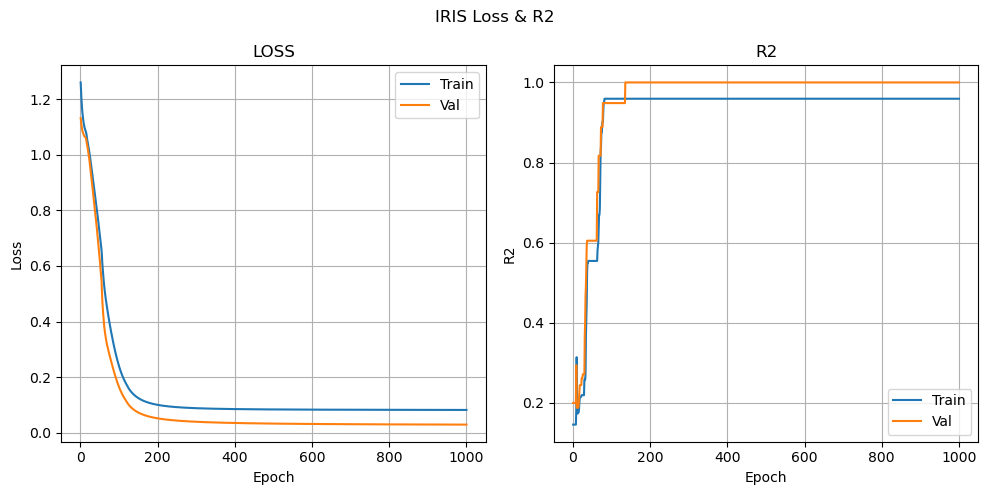

In [15]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

fg, axes=plt.subplots(1,2, figsize=(10,5), sharex=True)
fg.suptitle('IRIS Loss & R2')

axes[0].plot(range(1, EPOCH+1), LOSS_HISTORY[0][:EPOCH], label='Train')
axes[0].plot(range(1, EPOCH+1), LOSS_HISTORY[1][:EPOCH], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, EPOCH+1), SCORE_HISTORY[0][:EPOCH], label='Train')
axes[1].plot(range(1, EPOCH+1), SCORE_HISTORY[1][:EPOCH], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("R2")
axes[1].set_title("R2")

plt.tight_layout()
plt.show()

In [16]:
# 모델 검증 모드 설정
model.eval()
with torch.no_grad():
    # 검증 데이터셋
    test_featrueTS=torch.FloatTensor(testDS.featureDF.values)
    test_targetTS=torch.FloatTensor(testDS.targetDF.values)
        
    # 추론/평가
    pre_val=model(test_featrueTS)
    
    # 손실 / 성능평가
    loss_test=crossLoss(pre_val, test_targetTS.reshape(-1).long())
    score_test=MulticlassF1Score(num_classes=3)(pre_val, test_targetTS.reshape(-1))
    
print(f'- [TEST] LOSS : {loss_test.item()} SCORE : {score_test.item()}')

- [TEST] LOSS : 0.02708197943866253 SCORE : 1.0


3개 다중분류 >> 2진 3개

0과 나머지 => 확률 0.2
1과 나머지 => 확률 0.13
2과 나머지 => 확률 0.7333

3개의 확률 합계 1이 되도록
 AIGmax > 이걸로 2에 해당하는 인덱스를 뽑을수있다.
